In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import os
from PIL import Image
import torch

In [3]:
import cv2
import os
import numpy as np

def load_images(folder_path, label):
    image_data = []
    labels = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png',".JPG",'.JPEG','.PNG')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                img = cv2.resize(img, (224, 224))  # Resize the image as needed

                image_data.append(img)
                labels.append(label)

    return np.array(image_data), np.array(labels)

# Define folder paths
cancer_train_path = "/kaggle/input/skin-cancer-binary-classification-dataset/Skin_Data/Cancer/Training"
cancer_test_path = "/kaggle/input/skin-cancer-binary-classification-dataset/Skin_Data/Cancer/Testing"
non_cancer_train_path = "/kaggle/input/skin-cancer-binary-classification-dataset/Skin_Data/Non_Cancer/Training"
non_cancer_test_path = "/kaggle/input/skin-cancer-binary-classification-dataset/Skin_Data/Non_Cancer/Testing"

# Load images and labels for training
cancer_train_data, cancer_train_labels = load_images(cancer_train_path, 1)
non_cancer_train_data, non_cancer_train_labels = load_images(non_cancer_train_path, 0)

# Load images and labels for testing
cancer_test_data, cancer_test_labels = load_images(cancer_test_path, 1)
non_cancer_test_data, non_cancer_test_labels = load_images(non_cancer_test_path, 0)

# Concatenate cancer and non-cancer data
#trying flipping the dataset
X_train = np.concatenate((cancer_train_data, non_cancer_train_data), axis=0)
y_train = np.concatenate((cancer_train_labels, non_cancer_train_labels), axis=0)

X_test = np.concatenate((cancer_test_data, non_cancer_test_data), axis=0)
y_test = np.concatenate((cancer_test_labels, non_cancer_test_labels), axis=0)

In [4]:
cancer_train_data.shape

(42, 224, 224, 3)

In [5]:
models = [tf.keras.applications.InceptionV3, tf.keras.applications.InceptionResNetV2, tf.keras.applications.MobileNetV3Large, tf.keras.applications.ResNet152, tf.keras.applications.VGG19]
accuracy = []

In [6]:
def convert_to_binary(predictions, threshold):
    binary_predictions = (predictions > threshold).astype(int)
    return binary_predictions

In [7]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# # instantiate a distribution strategy
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [8]:
for inner_model in models:
    base_model = inner_model(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

# Add your own top layers for binary classification
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the new model
#     with tpu_strategy.scope():
    model = tf.keras.Model(inputs=base_model.input, outputs=x)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-3),loss=binary_crossentropy)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
    history = model.fit(X_train,y_train,epochs=100,batch_size=4,verbose=0,callbacks=[early_stopping])
    print(f"{inner_model} training done")
    ypreds = predictions = model.predict(X_test)
    # Example usage:
    predictions = ypreds
    threshold = 0.99

    binary_predictions = convert_to_binary(predictions, threshold)
    acc = accuracy_score(y_test,binary_predictions)
    accuracy.append([inner_model,acc,history])
    
# print("Original Predictions:", predictions)
# print("Binary Predictions:", binary_predictions)

87910968/87910968 [==============================] - 3s 0us/step
<function InceptionV3 at 0x7a958a8cfac0> training done
219055592/219055592 [==============================] - 7s 0us/step
<function InceptionResNetV2 at 0x7a958a8cf640> training done
12683000/12683000 [==============================] - 1s 0us/step
<function MobileNetV3Large at 0x7a958a788670> training done
234698864/234698864 [==============================] - 8s 0us/step
<function ResNet152 at 0x7a958a789bd0> training done
80134624/80134624 [==============================] - 3s 0us/step
<function VGG19 at 0x7a958a78b010> training done
7/7 [==============================] - 4s 233ms/step


0.8284313725490197
<function InceptionV3 at 0x7a958a8cfac0>


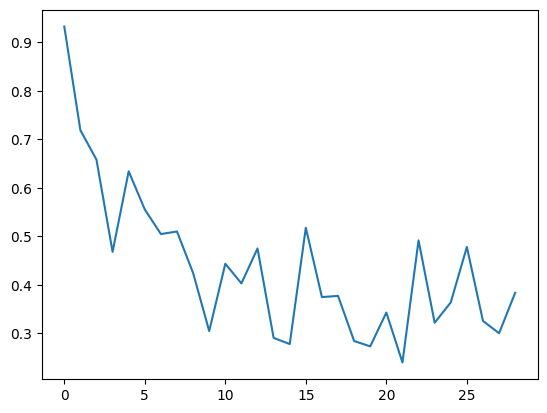

In [9]:
fig, ax = plt.subplots()
ax.plot(range(len(accuracy[0][2].history['loss'])),accuracy[0][2].history['loss'],label=f"{accuracy[0][0]}")
print(accuracy[0][1])
print(accuracy[0][0])

0.8088235294117647
<function InceptionResNetV2 at 0x7a958a8cf640>


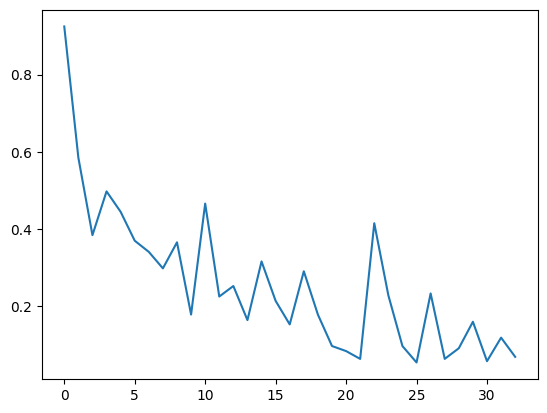

In [10]:
plt.plot(range(len(accuracy[1][2].history['loss'])),accuracy[1][2].history['loss'])
print(accuracy[1][1])
print(accuracy[1][0])

0.8333333333333334
<function MobileNetV3Large at 0x7a958a788670>


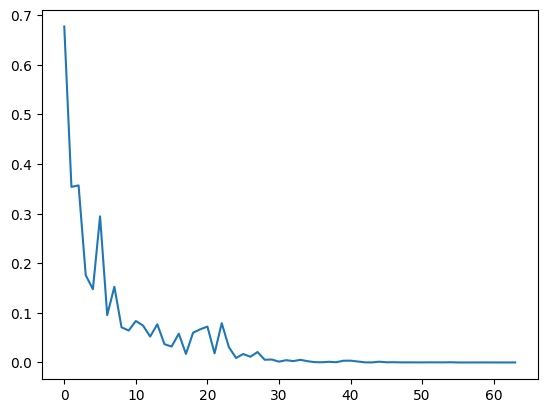

In [11]:
plt.plot(range(len(accuracy[2][2].history['loss'])),accuracy[2][2].history['loss'])
print(accuracy[2][1])
print(accuracy[2][0])

0.7892156862745098
<function ResNet152 at 0x7a958a789bd0>


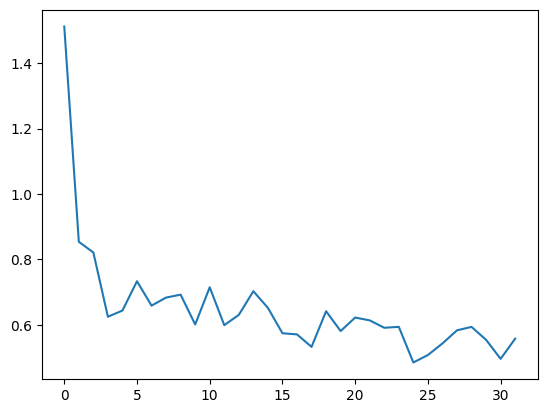

In [12]:
plt.plot(range(len(accuracy[3][2].history['loss'])),accuracy[3][2].history['loss'])
print(accuracy[3][1])
print(accuracy[3][0])

In [13]:
accuracy[0]

[<function keras.src.applications.inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')>,
 0.8284313725490197,